In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
sns.set(font_scale=1.5)
sns.set_palette("Set2")

from experiments import Status

This is the shape of the data, and how to produce it from inputs:

In [2]:
from collections import namedtuple

SMTCompResult = namedtuple("SMTCompResult", ["track", "benchmark_set", "benchmark", "solver", "status", "runtime"])

def parse_file(filepath):
    file = filepath.strip()
    parts = file.split("/")
    assert parts[-1][-5:] == ".smt2", f"{parts[-1]} does not end with .smt2!"
    return file, parts[0], parts[1]

def parse_outcome(outcome):
    outcome = outcome.strip().lower()
    if outcome == "sat":
        return Status.SAT
    if outcome == "unsat":
        return Status.UNSAT
    if "command exited" in outcome:
        return Status.ERROR
    if "command terminated" in outcome:
        return Status.ERROR
    if "parse error" in outcome:
        return Status.ERROR
    if "out of memory" in outcome:
        return Status.MEMORY_OUT
    if "error" in outcome:
        return Status.ERROR
    if "--" in outcome:
        return Status.ERROR
    if "unknown" == outcome:
        return Status.ERROR
    if "starexec-unknown" == outcome:
        return Status.ERROR
    assert False, f"Unknown status: {outcome}"

During SMT-COMP, specifically OSTRICH and Z3-noodler got a re-run of some of the experiments, we splice in those results:

In [3]:
smt_comp = pd.read_csv("Job59410_info.zip")
smt_comp_fixed = pd.read_csv("Job59668_info.zip")
fixed_solvers = smt_comp_fixed[smt_comp_fixed["solver"].isin(["OSTRICH 1.3 SMT-COMP fixed", "Z3-Noodler"])]
smt_comp = smt_comp[~smt_comp.solver.isin(["OSTRICH 1.3 SMT-COMP", "Z3-Noodler"])]
smt_comp = pd.concat([smt_comp, fixed_solvers])
smt_comp['benchmark'] = smt_comp['benchmark'].str.replace("track_single_query/", "")

Apparently, there are benchmarks in the set that weren't part of SMT-COMP, so we just ignore those for an apples-to-applescomparison:

In [4]:
used_benchmarks = smt_comp.benchmark.unique()

Now, we load our own re-runs of SMT-COMP with Ostrich x CATRA, and splice those in too:

In [5]:
catra_qf_snia = pd.read_csv("Job62395_info_QF_SNIA.zip")
catra_qf_s = pd.read_csv("Job62397_info_QF_S.zip")
catra_qf_slia = pd.read_csv("Job62396_info_QF_SLIA.zip")
catra_results = pd.concat([catra_qf_snia, catra_qf_slia, catra_qf_s])
catra_results = catra_results[catra_results.benchmark.isin(used_benchmarks)]

In [6]:
smt_comp = pd.concat([smt_comp, catra_results])

And then we clean up the labelling slightly:

In [7]:
smt_comp = smt_comp.rename(columns={"wallclock time": "runtime"})
smt_comp['track'] = smt_comp.benchmark.apply(lambda x: parse_file(x)[1])
smt_comp = smt_comp[smt_comp['track'].isin(["QF_S", "QF_SLIA", "QF_SNIA"])]

smt_comp['benchmark_set'] = smt_comp.benchmark.apply(lambda x: parse_file(x)[2])
smt_comp['status'] = smt_comp["result"].apply(parse_outcome)
smt_comp = smt_comp.drop(columns=["result"])

Now we set up categories for Pandas, and order outcomes (SAT etc) such that SAT wins over UNSAT, which wins over TIMEOUT, which, ... etc.

In [8]:
smt_comp['solver'] = smt_comp['solver'].astype("category")
smt_comp['status'] = smt_comp['status'].astype("category")
smt_comp['track'] = smt_comp['track'].astype("category")
smt_comp['benchmark'] = smt_comp['benchmark'].astype("category")
smt_comp['benchmark_set'] = smt_comp['benchmark_set'].astype("category")
smt_comp['status'] = smt_comp['status'].cat.set_categories([Status.SAT, Status.UNSAT, Status.TIMEOUT, Status.MEMORY_OUT, Status.ERROR], ordered=True)
smt_comp = smt_comp.drop(["solver id", "benchmark id", "configuration id", "cpu time", "memory usage", "pair id"], axis=1)
# This fills NaN columns using the first non-NaN value in the group, essentially populating expected outcomes etc.
smt_comp.update(smt_comp.groupby(['benchmark'])[['expected', 'configuration']].bfill())
smt_comp.update(smt_comp.groupby(['benchmark'])[['expected', 'configuration']].ffill())

For some reason, some results are missing for Z3-Noodler?!

In [9]:
smt_comp.groupby('solver').size()

solver
OSTRICH 1.3 SMT-COMP fixed           30855
Ostrich CA-Str                       30855
Z3-Noodler                           30785
cvc5-default-2023-05-16-ea045f305    30855
z3alpha                              30855
dtype: int64

In [30]:
len(smt_comp[smt_comp.track == "QF_S"].benchmark.unique())

8847

Create a new solver which is the best output of ostrich and ostrich-catra:

In [10]:
portfolio_results = smt_comp[smt_comp.solver.isin(["Ostrich CA-Str", "OSTRICH 1.3 SMT-COMP fixed"])]\
    .sort_values(['status', 'runtime'])\
    .groupby("benchmark")\
    .first()\
    .reset_index()\
    .assign(solver="Ostrich portfolio")

We also create a portfolio for *every solver that isn't Ostrich*:

In [11]:
smt_comp = pd.concat([smt_comp, portfolio_results])

In [12]:
portfolio_all = smt_comp[~smt_comp.solver.isin(["Ostrich CA-Str", "OSTRICH 1.3 SMT-COMP fixed"])]\
    .sort_values(['status', 'runtime'])\
    .groupby("benchmark")\
    .first()\
    .reset_index()\
    .assign(solver="All competitors")

In [13]:
smt_comp = pd.concat([smt_comp, portfolio_all])

In [14]:
smt_comp.groupby('solver').size()

solver
All competitors                      30855
OSTRICH 1.3 SMT-COMP fixed           30855
Ostrich CA-Str                       30855
Ostrich portfolio                    30855
Z3-Noodler                           30785
cvc5-default-2023-05-16-ea045f305    30855
z3alpha                              30855
dtype: int64

## Soundness check
Here we group by benchmark and status to see if there are diverging opinions about satisfiability.

In [15]:
success_runs = smt_comp[smt_comp['status'] < Status.TIMEOUT]
success_runs_by_instance = success_runs.groupby(['benchmark'])

nr_statuses = success_runs_by_instance.status.nunique().reset_index()
contested = nr_statuses[nr_statuses['status'] > 1]
contested

,benchmark,status
4823,QF_S/20230329-automatark-lu/instance08425.smt2,2
19887,QF_SLIA/2019-Jiang/slent/slent_stranger_str_re...,2


In [16]:
smt_comp[(smt_comp.benchmark.isin(contested.benchmark)) & (smt_comp.status < Status.TIMEOUT)]\
    .set_index(["benchmark", "solver"])\
    .drop(["track", "runtime", "configuration", "benchmark_set"], axis=1) \
    .sort_values("benchmark")

status  \
benchmark                                          solver                                            
QF_S/20230329-automatark-lu/instance08425.smt2     cvc5-default-2023-05-16-ea045f305    Status.SAT   
                                                   z3alpha                              Status.SAT   
                                                   OSTRICH 1.3 SMT-COMP fixed           Status.SAT   
                                                   Z3-Noodler                           Status.SAT   
                                                   Ostrich CA-Str                     Status.UNSAT   
                                                   Ostrich portfolio                    Status.SAT   
                                                   All competitors                      Status.SAT   
QF_SLIA/2019-Jiang/slent/slent_stranger_str_rep... cvc5-default-2023-05-16-ea045f305    Status.SAT   
                                                   z3alpha                              Status.SAT   
                                                   Z3-Noodler                         Status.UNSAT   
                                                   All competitors                      Status.SAT   

                                                                                              expected  
benchmark                                          solver                                               
QF_S/20230329-automatark-lu/instance08425.smt2     cvc5-default-2023-05-16-ea045f305               sat  
                                                   z3alpha                                         sat  
                                                   OSTRICH 1.3 SMT-COMP fixed                      sat  
                                                   Z3-Noodler                                      sat  
                                                   Ostrich CA-Str                                  sat  
                                                   Ostrich portfolio                               sat  
                                                   All competitors                                 sat  
QF_SLIA/2019-Jiang/slent/slent_stranger_str_rep... cvc5-default-2023-05-16-ea045f305  starexec-unknown  
                                                   z3alpha                            starexec-unknown  
                                                   Z3-Noodler                         starexec-unknown  
                                                   All competitors                    starexec-unknown

We manually change the result to an error (and leave an assertion to poke us if it changes):

In [17]:
contested_names = set(["QF_SLIA/2019-Jiang/slent/slent_stranger_str_rep_19543_sink.smt2", "QF_S/20230329-automatark-lu/instance08425.smt2"])
assert set(contested.benchmark) == set(contested_names)

smt_comp.loc[(smt_comp.solver=="Z3-Noodler") \
               & (smt_comp.benchmark=="QF_SLIA/2019-Jiang/slent/slent_stranger_str_rep_19543_sink.smt2"), \
               "status"] = Status.ERROR

smt_comp.loc[(smt_comp.solver=="Ostrich CA-Str") \
               & (smt_comp.benchmark=="QF_S/20230329-automatark-lu/instance08425.smt2"), \
               "status"] = Status.ERROR


In [18]:
smt_comp[smt_comp['status'] > Status.TIMEOUT]

,benchmark,solver,configuration,status,runtime,expected,track,benchmark_set
271177,QF_S/2019-Jiang/slog/slog_stranger_1820_sink.smt2,z3alpha,default,Status.ERROR,1200.110000,starexec-unknown,QF_S,2019-Jiang
274040,QF_S/20230329-automatark-lu/instance14134.smt2,cvc5-default-2023-05-16-ea045f305,sq,Status.ERROR,1200.120000,sat,QF_S,20230329-automatark-lu
274213,QF_S/20230329-automatark-lu/instance12439.smt2,z3alpha,default,Status.ERROR,1200.030000,starexec-unknown,QF_S,20230329-automatark-lu
275109,QF_S/20230329-automatark-lu/instance14003.smt2,z3alpha,default,Status.ERROR,33.236100,starexec-unknown,QF_S,20230329-automatark-lu
275120,QF_S/20230329-automatark-lu/instance08782.smt2,cvc5-default-2023-05-16-ea045f305,sq,Status.ERROR,1200.030000,starexec-unknown,QF_S,20230329-automatark-lu
...,...,...,...,...,...,...,...,...
30603,QF_SLIA/20230403-webapp/str-rep-all/str_replac...,All competitors,default,Status.ERROR,0.031778,starexec-unknown,QF_SLIA,20230403-webapp
30646,QF_SLIA/20230403-webapp/str-rep-all/str_replac...,All competitors,default,Status.ERROR,0.036893,starexec-unknown,QF_SLIA,20230403-webapp
30654,QF_SLIA/20230403-webapp/str-rep-all/str_replac...,All competitors,default,Status.ERROR,0.038940,starexec-unknown,QF_SLIA,20230403-webapp
30658,QF_SLIA/20230403-webapp/str-rep-all/str_replac...,All competitors,default,Status.ERROR,0.037101,starexec-unknown,QF_SLIA,20230403-webapp


In [19]:
def plot_results(df, title="Outcome by solver"):
    fig, ax = plt.subplots()
    runtime_by_status = df.groupby(['solver', 'status']).size().reset_index()
    runtime_by_status = runtime_by_status[runtime_by_status[0] > 0]
    runtime_by_status.rename(columns = {0: 'count'}, inplace = True)
    runtime_by_status = runtime_by_status.set_index(['solver', 'status'])
    plot = runtime_by_status.unstack().plot.bar(figsize=(10,6), 
                                     stacked=True, 
                                     ylabel="nr instances",
                                     title=title, 
                                     ax=ax)


    nr_solvers = df.solver.nunique()
    bars = plot.patches
    hatches = [ *(["*"] * nr_solvers), *(["."] * nr_solvers), *(["/"] * nr_solvers), *(["x"] * nr_solvers)]


    for bar, hatch in zip(bars, hatches):
        bar.set_hatch(hatch)

    ax.legend([str(heading).replace("Status.", "") for _, heading in runtime_by_status.unstack().columns])


#plt.tight_layout()
#plt.savefig(f'{commit}-by-solver.pdf', dpi=300)

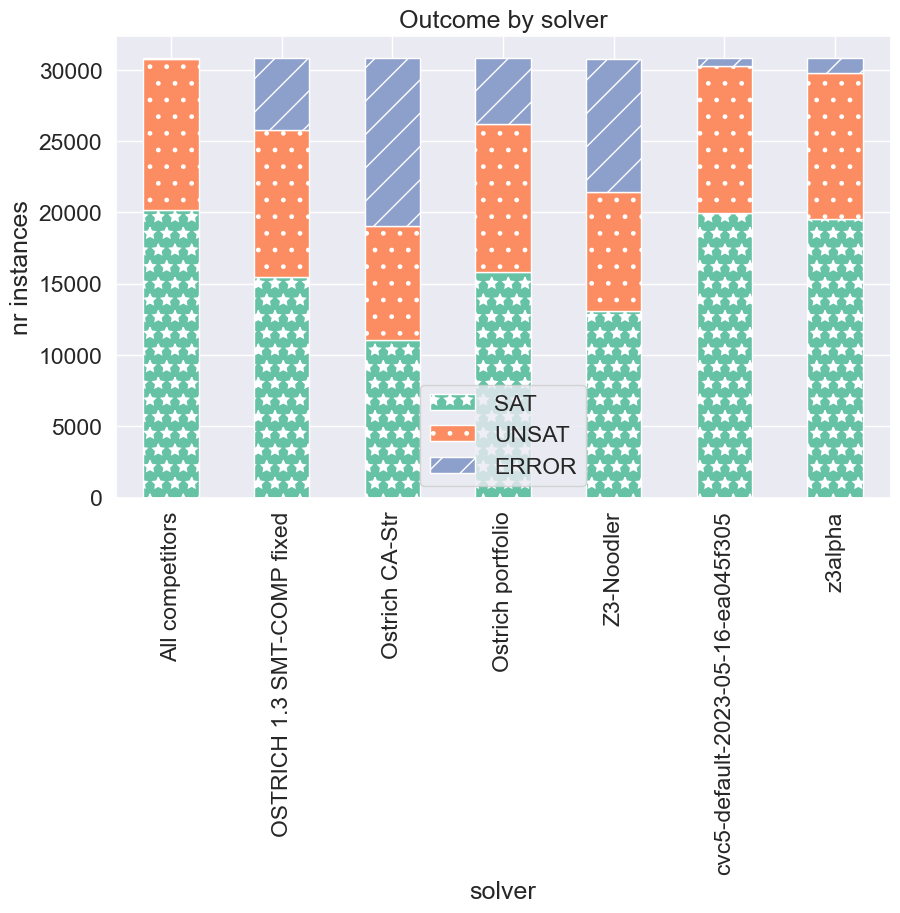

In [20]:
plot_results(smt_comp)

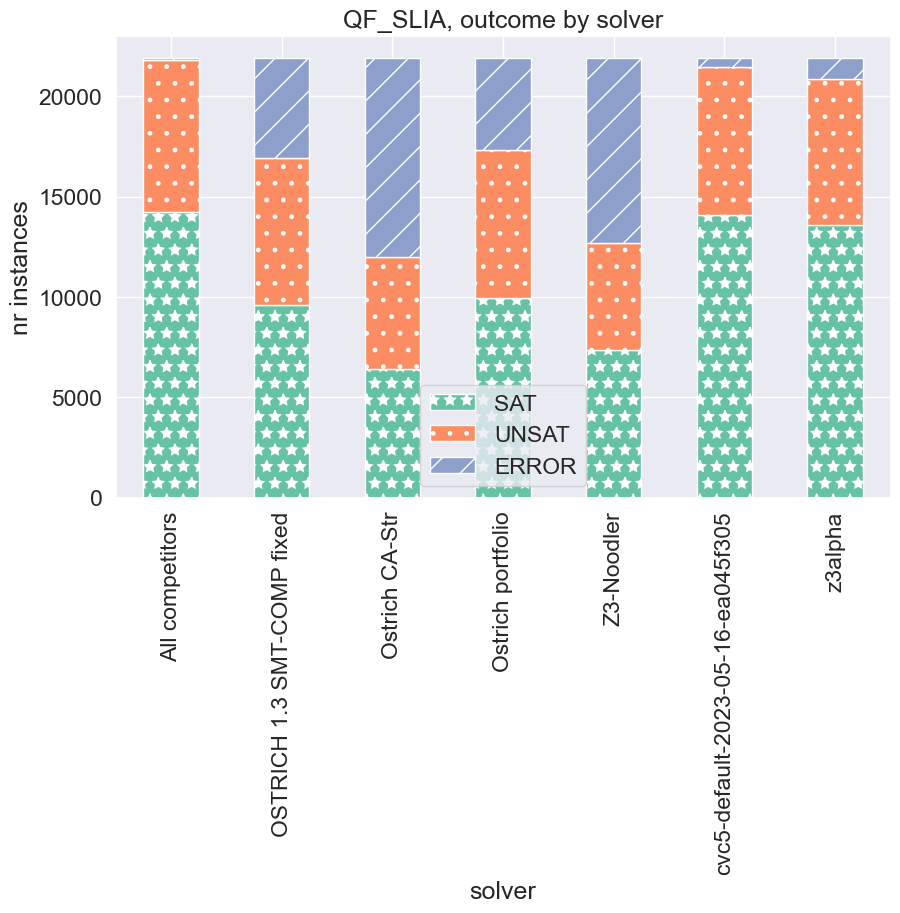

In [21]:
plot_results(smt_comp[(smt_comp.track == "QF_SLIA")], "QF_SLIA, outcome by solver")

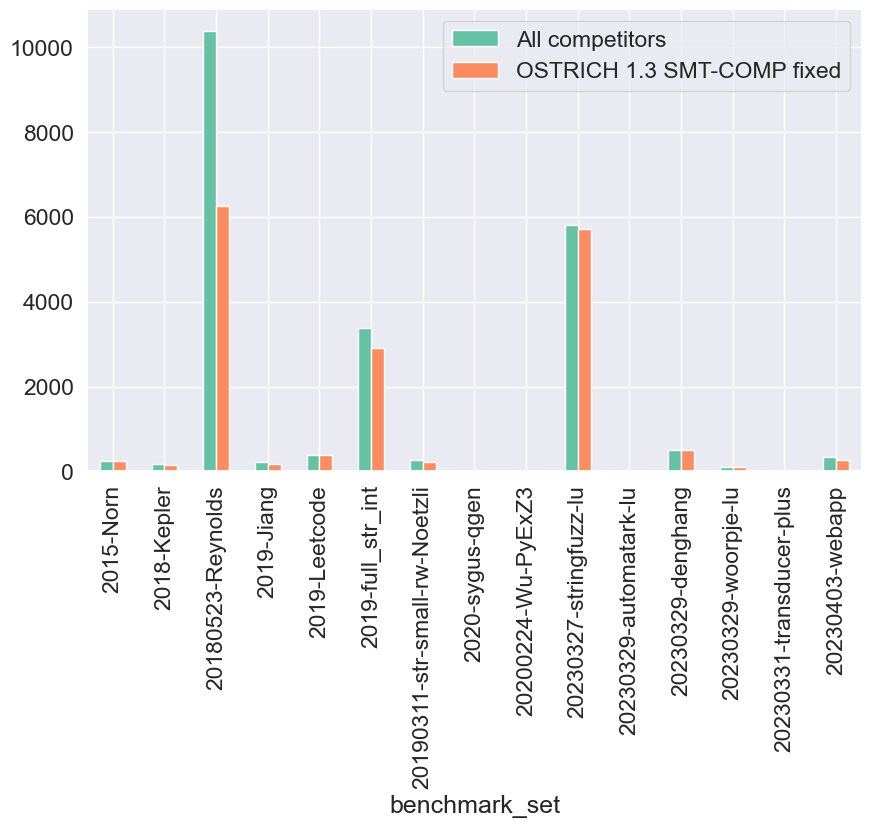

In [22]:
fig, ax = plt.subplots()


smt_comp[(smt_comp.track == 'QF_SLIA') & (smt_comp.solver.isin(["OSTRICH 1.3 SMT-COMP fixed", "both OSTRICHes", "All competitors"])) & (smt_comp.status < Status.TIMEOUT)]\
    .groupby(["benchmark_set", "solver"])\
    .size()\
    .reset_index()\
    .rename(columns = {0: 'solved'})\
    .set_index(["benchmark_set", "solver"])\
    .unstack()\
    .plot\
    .bar(ax=ax, figsize=(10,6))

_, labels = ax.get_legend_handles_labels()

ax.legend(list(map(lambda x: x.replace("solved, ", "").replace("(", "").replace(")", ""), labels)))

In [31]:
by_sat_status = pd.DataFrame(smt_comp.groupby('benchmark').status.min())
by_sat_status['kind'] = by_sat_status['status'].astype("category")
by_sat_status['kind'] = by_sat_status.kind.cat.set_categories([Status.SAT, Status.UNSAT])
del(by_sat_status['status'])

known_solved_with_kind = smt_comp[smt_comp['status'] < Status.TIMEOUT]\
    .join(by_sat_status, on='benchmark')

tbl = pd.pivot_table(known_solved_with_kind[known_solved_with_kind.track == "QF_SLIA"], values=['runtime'], 
               index=['kind'], columns=['solver'],
               aggfunc='count')['runtime']
tbl.index = tbl.index.to_series().map(lambda x: str(x).replace("Status.", ""))
tbl.style.to_latex("qf_slia_comparison.tex", hrules=True)
tbl

solver,All competitors,OSTRICH 1.3 SMT-COMP fixed,Ostrich CA-Str,Ostrich portfolio,Z3-Noodler,cvc5-default-2023-05-16-ea045f305,z3alpha
kind,,,,,,,
SAT,14217,9586,6427,9930,7344,14069,13599
UNSAT,7601,7356,5562,7387,5367,7377,7298


## Per-track results

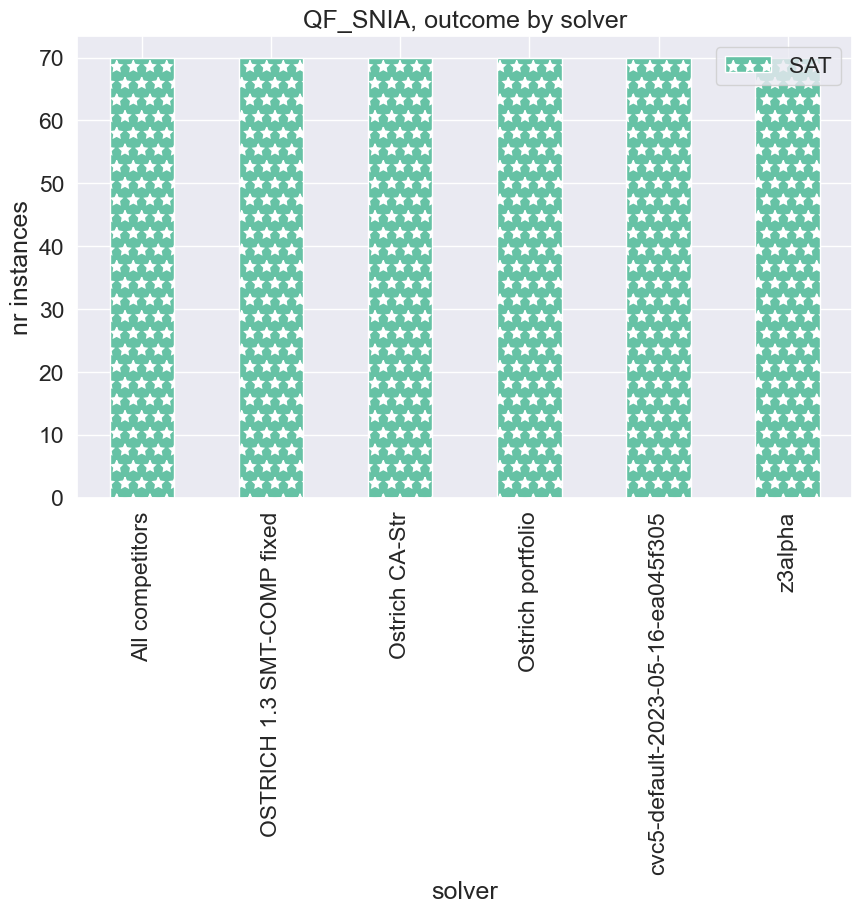

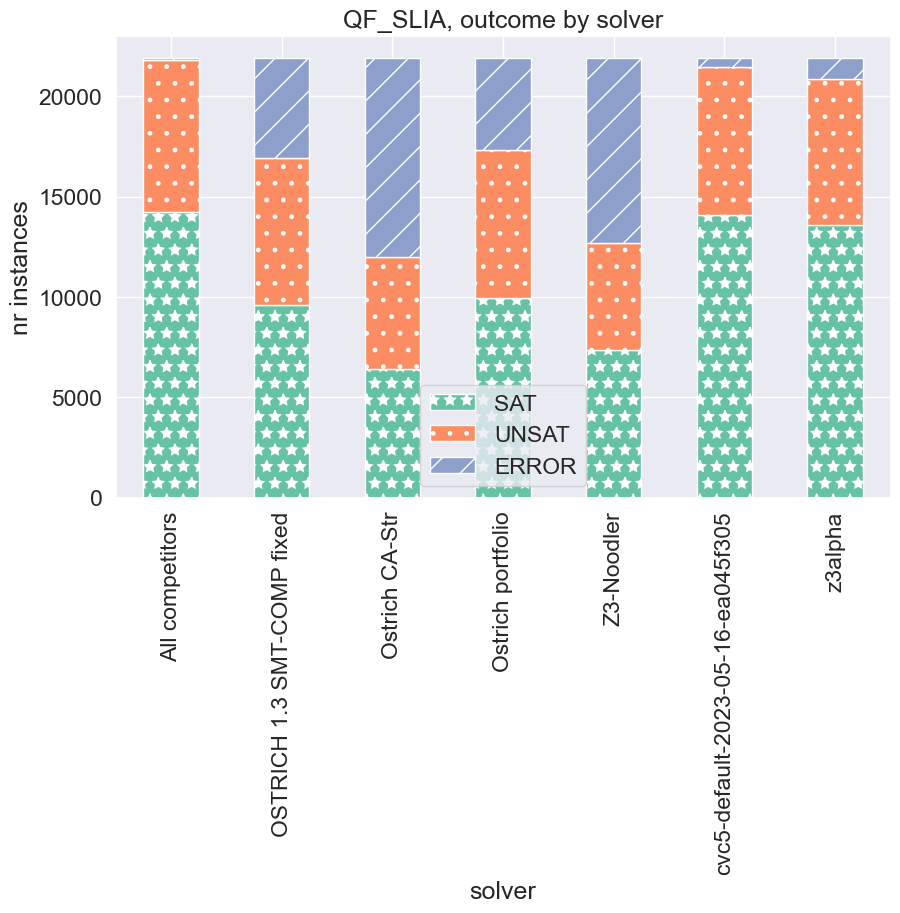

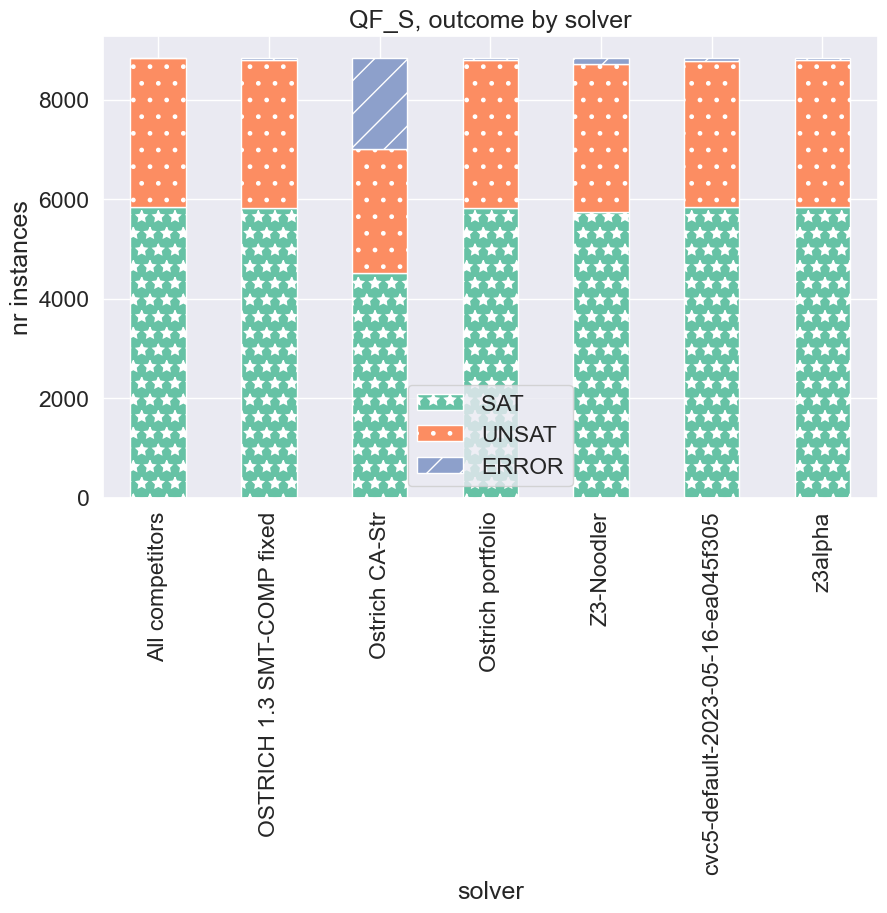

In [24]:
for track in ["QF_SNIA", "QF_SLIA", "QF_S"]:
    plot_results(smt_comp[(smt_comp.track == track)], f"{track}, outcome by solver")